# Trabajo Práctico: Exploración y Preparación de Airbnb Listings


## Objetivo
En esta libreta analizamos el dataset `listings_big.csv` para comprender su estructura, diagnosticar problemas de calidad y preparar un conjunto de features apto para entrenar un modelo supervisado. El flujo general incluye:
- Exploración inicial y resumen estadístico
- Detección de valores faltantes y outliers
- Visualizaciones que permitan interpretar patrones relevantes
- Definición de un problema de precios como regresión supervisada
- Construcción de un pipeline de preprocesamiento, ingeniería de variables y reducción de dimensionalidad


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 5)
pd.set_option('display.max_columns', 80)

DATA_PATH = Path('listings_big.csv')


## 1. Carga y saneamiento inicial


In [2]:
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
# Limpieza de precios: eliminar símbolos y convertir a numérico
df['price'] = (df['price']
               .astype(str)
               .str.replace(r'[€$£,]', '', regex=True)
               .str.strip())
df['price'] = pd.to_numeric(df['price'], errors='coerce')
# Conversión de columnas fecha para posteriores features
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')
# Normalización de flags binarias
def to_bool(series):
    mapped = series.map({'t': 'yes', 'f': 'no'})
    return mapped.astype('object')
for col in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']:
    if col in df.columns:
        df[col] = to_bool(df[col])
print(f"Shape original: {df_raw.shape}")
print(f"Shape después de transformaciones básicas: {df.shape}")


Shape original: (35172, 79)
Shape después de transformaciones básicas: (35172, 79)


### 1.1 Información general del dataset


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35172 entries, 0 to 35171
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            35172 non-null  int64         
 1   listing_url                                   35172 non-null  object        
 2   scrape_id                                     35172 non-null  int64         
 3   last_scraped                                  35172 non-null  datetime64[ns]
 4   source                                        35172 non-null  object        
 5   name                                          35172 non-null  object        
 6   description                                   34299 non-null  object        
 7   neighborhood_overview                         16588 non-null  object        
 8   picture_url                                   35171 non-null  obje

In [4]:
# Resumen de tipos de columnas y conteo por tipo
type_summary = df.dtypes.value_counts().rename('count').to_frame()
type_summary


,count
object,30
int64,24
float64,21
datetime64[ns],4


In [5]:
# Estadísticas descriptivas de variables numéricas
numeric_summary = df.select_dtypes(include=[np.number]).describe().T
numeric_summary


,count,mean,std,min,25%,50%,75%,max
id,35172.0,7.117880e+17,4.840974e+17,1.150800e+04,4.719776e+07,8.875662e+17,1.095206e+18,1.344330e+18
scrape_id,35172.0,2.025013e+13,0.000000e+00,2.025013e+13,2.025013e+13,2.025013e+13,2.025013e+13,2.025013e+13
host_id,35172.0,2.143294e+08,2.027420e+08,1.342600e+04,3.070016e+07,1.421004e+08,4.298024e+08,6.754917e+08
host_listings_count,35166.0,1.953964e+01,4.128934e+01,1.000000e+00,1.000000e+00,3.000000e+00,1.600000e+01,6.700000e+02
host_total_listings_count,35166.0,2.942555e+01,7.958366e+01,1.000000e+00,1.000000e+00,4.000000e+00,2.000000e+01,2.542000e+03
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,35172.0,-3.459155e+01,1.825693e-02,-3.469370e+01,-3.460267e+01,-3.459089e+01,-3.458105e+01,-3.453498e+01
longitude,35172.0,-5.841729e+01,3.016859e-02,-5.853089e+01,-5.843705e+01,-5.841891e+01,-5.839211e+01,-5.835540e+01
accommodates,35172.0,2.943535e+00,1.550894e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,31602.0,1.236504e+00,6.569959e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.200000e+01


In [6]:
# Estadísticas básicas de variables categóricas/cadenas
categorical_cols = df.select_dtypes(include=['object', 'string']).columns
categorical_summary = df[categorical_cols].describe().T
categorical_summary.head(20)


,count,unique,top,freq
listing_url,35172,35172,https://www.airbnb.com/rooms/11508,1
source,35172,2,city scrape,31613
name,35172,32871,Departamento en Buenos Aires,98
description,34299,30441,Enjoy the simplicity of this quiet and central...,148
neighborhood_overview,16588,13465,"San Telmo, a historic neighborhood in Buenos A...",64
picture_url,35171,34512,https://a0.muscache.com/pictures/hosting/Hosti...,9
host_url,35172,17820,https://www.airbnb.com/users/show/11256892,222
host_name,35166,4344,Federico,533
host_location,27619,742,"Buenos Aires, Argentina",22667
host_about,18881,7371,Amamos al mundo y nos encanta viajar en él!\nB...,222


### 1.2 Exploración de duplicados y consistencia


In [7]:
duplicate_count = df.duplicated(subset=['id']).sum()
print(f"Duplicados basados en 'id': {duplicate_count}")

missing_ids = df['id'].isna().sum()
print(f"IDs faltantes: {missing_ids}")


Duplicados basados en 'id': 0
IDs faltantes: 0


## 2. Valores faltantes


In [8]:
missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct})
missing_table.head(20)


,missing,percent
neighbourhood_group_cleansed,35172,1.0000
calendar_updated,35172,1.0000
license,34782,0.9889
neighbourhood,18584,0.5284
neighborhood_overview,18584,0.5284
host_about,16291,0.4632
host_neighbourhood,13451,0.3824
host_location,7553,0.2147
review_scores_value,5761,0.1638
review_scores_accuracy,5761,0.1638


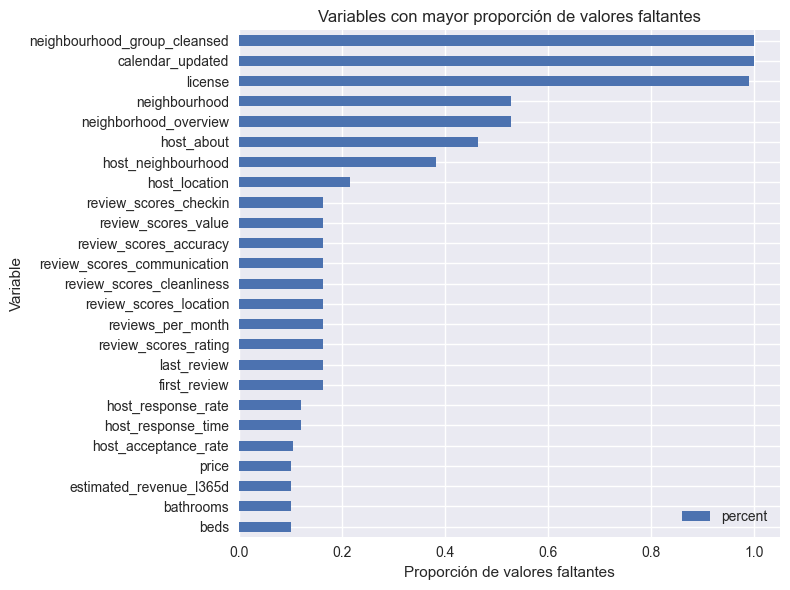

In [9]:
# Visualización del top de variables con mayor porcentaje de faltantes
top_missing = missing_table[missing_table['percent'] > 0].head(25)
ax = top_missing.sort_values('percent').plot.barh(y='percent', figsize=(8, 6))
ax.set_xlabel('Proporción de valores faltantes')
ax.set_ylabel('Variable')
ax.set_title('Variables con mayor proporción de valores faltantes')
plt.tight_layout()
plt.show()


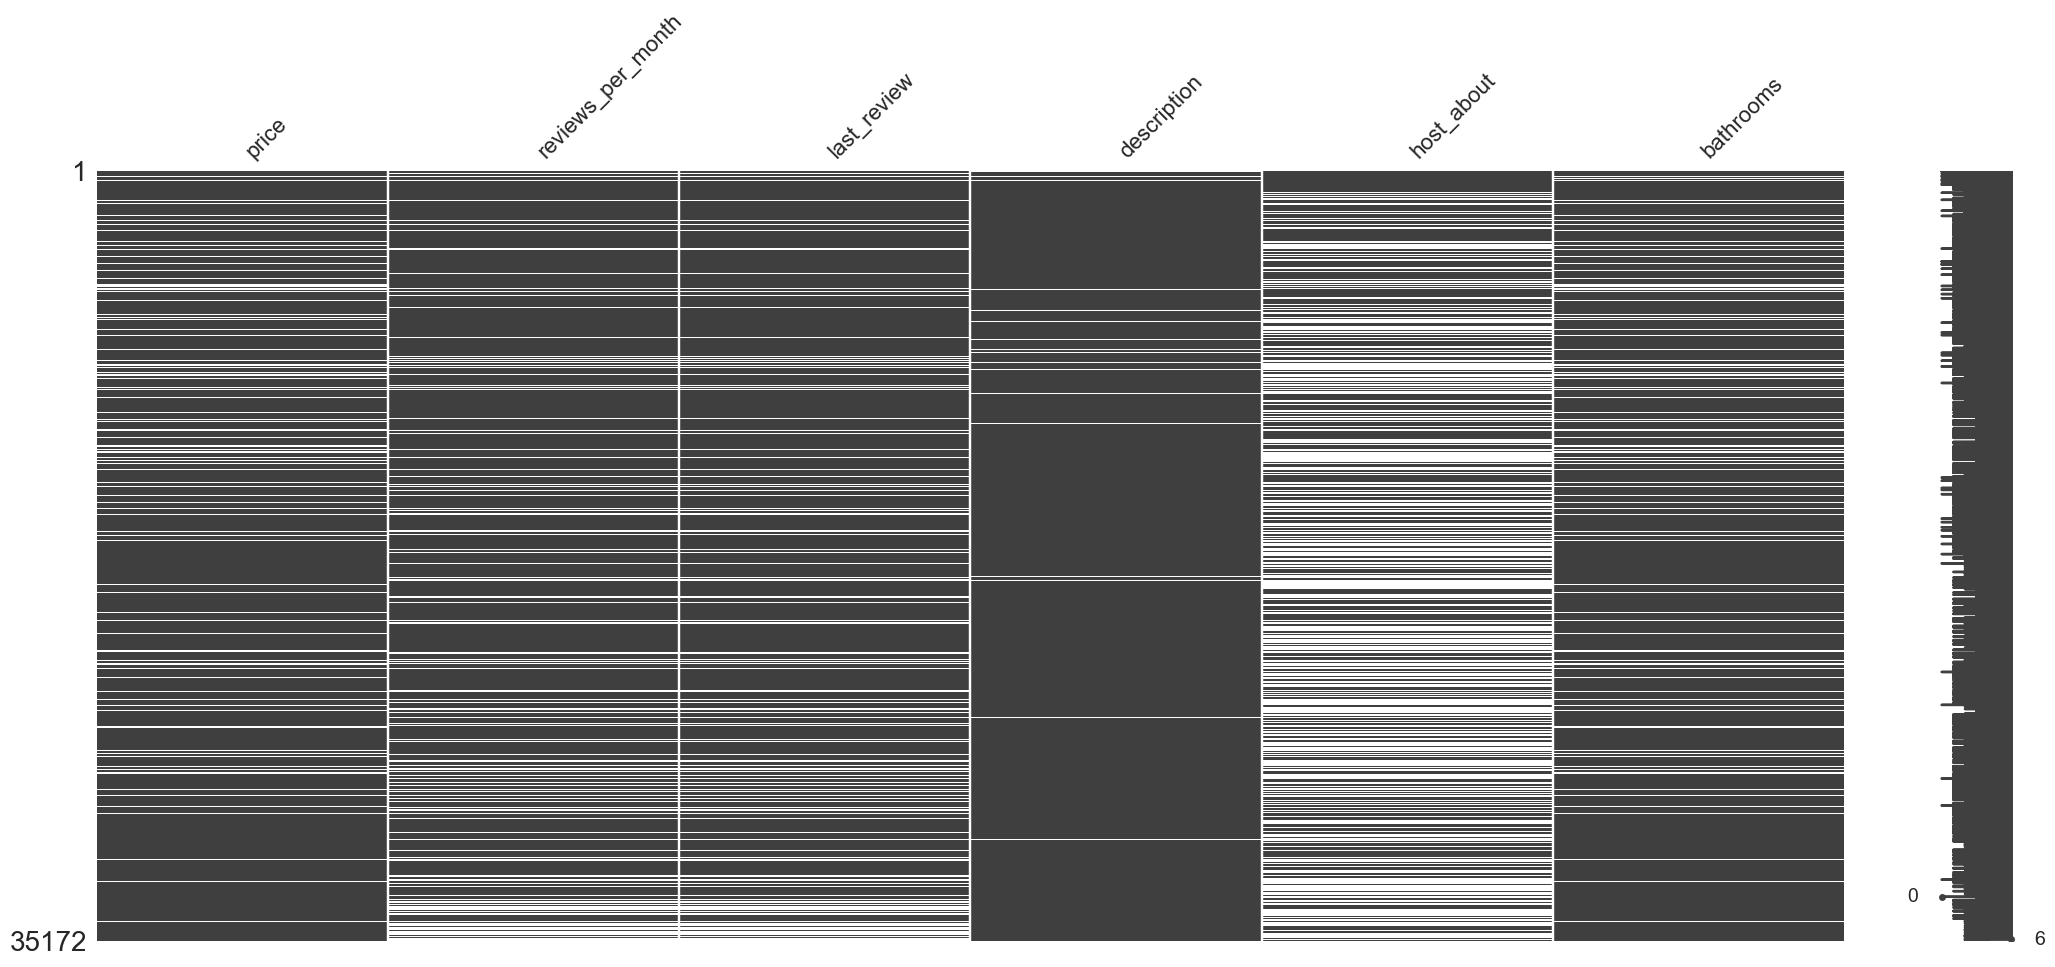

In [10]:
# Matriz de missingness para detectar patrones
try:
    import missingno as msno
    msno.matrix(df[['price', 'reviews_per_month', 'last_review', 'description', 'host_about', 'bathrooms']])
    plt.show()
except ImportError:
    print('missingno no está disponible en el entorno actual.')


In [11]:
# Ejemplo de análisis MAR/MNAR: comparar reviews_per_month faltante vs número de reviews
reviews_missing_flag = df['reviews_per_month'].isna()
comparison = df.groupby(reviews_missing_flag)['number_of_reviews'].agg(['mean', 'median', 'count'])
comparison.index = ['reviews_per_month disponible', 'reviews_per_month faltante']
comparison


,mean,median,count
reviews_per_month disponible,33.516456,17.0,29412
reviews_per_month faltante,0.000000,0.0,5760


**Interpretación inicial:** La ausencia de `reviews_per_month` suele darse en listados sin reseñas recientes, sugiriendo un mecanismo MAR (dependiente de `number_of_reviews`).


## 3. Distribuciones y visualizaciones clave


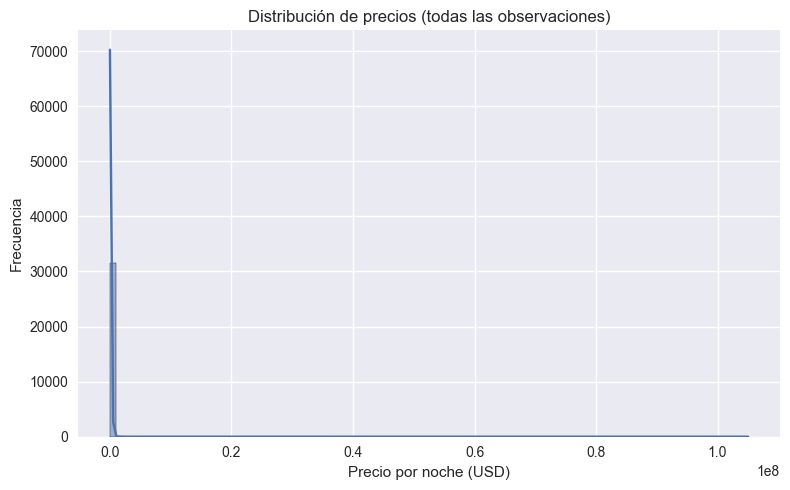

In [12]:
sns.histplot(df['price'].dropna(), bins=100, kde=True)
plt.title('Distribución de precios (todas las observaciones)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


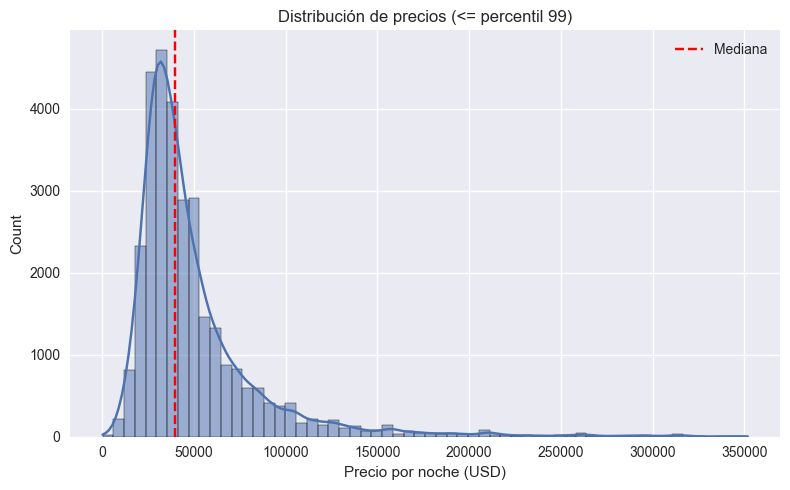

In [13]:
# Distribución recortando el 1% superior para atenuar outliers
price_cap = df['price'].quantile(0.99)
sns.histplot(df.loc[df['price'] <= price_cap, 'price'], bins=60, kde=True)
plt.axvline(df['price'].median(), color='red', linestyle='--', label='Mediana')
plt.title('Distribución de precios (<= percentil 99)')
plt.xlabel('Precio por noche (USD)')
plt.legend()
plt.tight_layout()
plt.show()


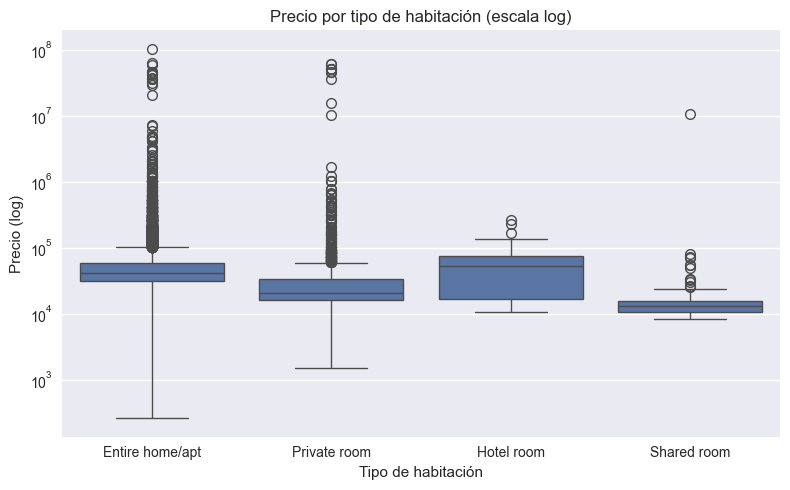

In [14]:
sns.boxplot(data=df, x='room_type', y='price')
plt.yscale('log')
plt.title('Precio por tipo de habitación (escala log)')
plt.xlabel('Tipo de habitación')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


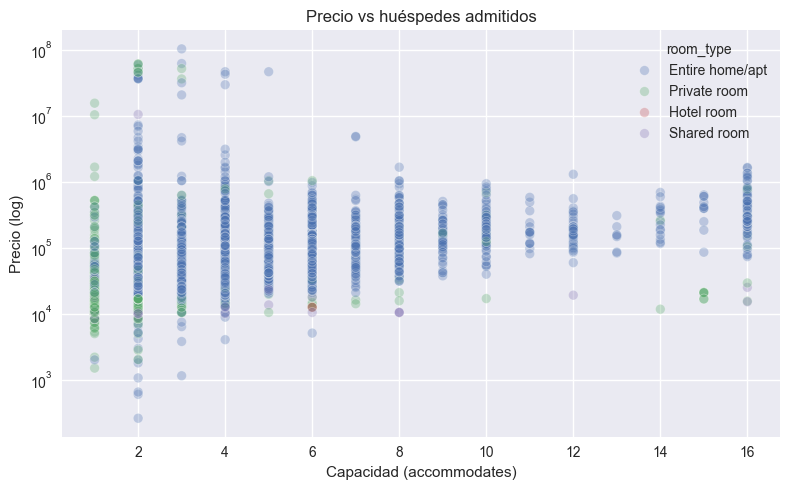

In [15]:
# Precio vs capacidad
sns.scatterplot(data=df, x='accommodates', y='price', hue='room_type', alpha=0.3)
plt.yscale('log')
plt.title('Precio vs huéspedes admitidos')
plt.xlabel('Capacidad (accommodates)')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


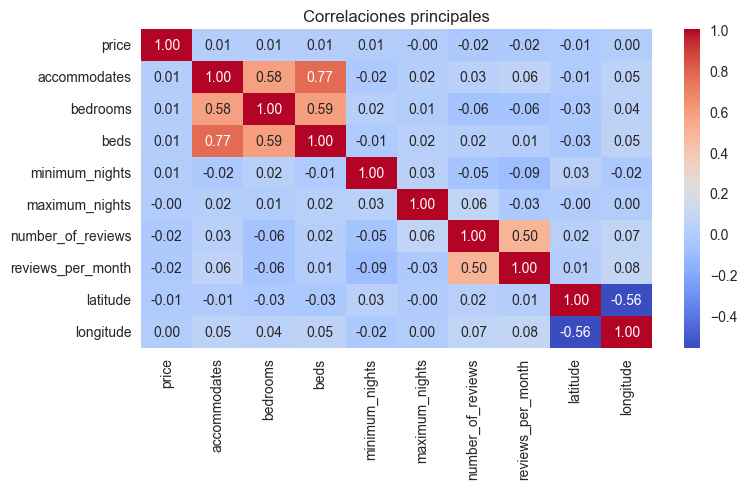

In [16]:
# Correlación entre variables numéricas relevantes
num_cols_for_corr = ['price', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'reviews_per_month', 'latitude', 'longitude']
cor_matrix = df[num_cols_for_corr].corr(numeric_only=True)
sns.heatmap(cor_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlaciones principales')
plt.tight_layout()
plt.show()


## 4. Detección y tratamiento de outliers


In [17]:
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

price_lower, price_upper = iqr_bounds(df['price'].dropna())
print(f'Umbral inferior: {price_lower:.2f}')
print(f'Umbral superior: {price_upper:.2f}')

outlier_flags = (df['price'] < price_lower) | (df['price'] > price_upper)
print(f'Outliers detectados por IQR: {outlier_flags.sum()} ({outlier_flags.mean():.2%})')

# Propuesta: winsorizar al percentil 1/99 para el set de modelado
df['price_winsorized'] = df['price'].clip(lower=df['price'].quantile(0.01), upper=df['price'].quantile(0.99))


Umbral inferior: -12365.50
Umbral superior: 99838.50
Outliers detectados por IQR: 2693 (7.66%)


**Decisión:** Se utilizará `price_winsorized` como target modelo para mitigar efectos extremos sin descartar observaciones valiosas.


## 5. Planteo del problema supervisado


Proponemos un problema de **regresión** donde la variable target es `price_winsorized` (precio por noche tras acotar outliers). El objetivo es estimar el precio esperado de un listado a partir de características del hospedaje. Se evaluaría con métricas como RMSE o MAE.

Se trabajará con un subconjunto de variables relevantes que combinan atributos de ubicación (`latitude`, `longitude`, `neighbourhood_cleansed`), capacidad (`accommodates`, `bedrooms`, `beds`, `minimum_nights`), reputación (`number_of_reviews`, `reviews_per_month`, `host_is_superhost`) y configuración (`room_type`, `property_type`, `instant_bookable`).


## 6. Ingeniería de features y preprocesamiento


In [18]:
# Feature engineering básico
# Imputar reseñas por mes faltantes con 0 (sugiere ausencia de reseñas)
df['reviews_per_month_filled'] = df['reviews_per_month'].fillna(0)

# Antigüedad del host y tiempo desde la última reseña
reference_date = df['last_scraped'].max()
df['host_tenure_days'] = (reference_date - df['host_since']).dt.days

# Si host_since es NA, el resultado será NA y se imputará más adelante
df['days_since_last_review'] = (reference_date - df['last_review']).dt.days

# Densidad de reseñas: reviews acumulados sobre tenure (evitar división por cero)
df['reviews_per_year'] = df['number_of_reviews'] / (df['host_tenure_days'] / 365)
df.loc[df['host_tenure_days'] <= 0, 'reviews_per_year'] = np.nan

feature_cols = [
    'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude',
    'host_is_superhost', 'instant_bookable', 'room_type', 'property_type',
    'neighbourhood_cleansed', 'host_tenure_days', 'days_since_last_review', 'reviews_per_year'
]

# Dataset para modelado
model_df = df[feature_cols + ['price_winsorized']].copy()
model_df.head()


,accommodates,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,reviews_per_month_filled,latitude,longitude,host_is_superhost,instant_bookable,room_type,property_type,neighbourhood_cleansed,host_tenure_days,days_since_last_review,reviews_per_year,price_winsorized
0,2,1.0,1.0,3,1125,44,0.29,-34.581840,-58.424150,yes,no,Entire home/apt,Entire condo,Palermo,5603.0,7.0,2.866322,67518.0
1,2,1.0,1.0,7,40,123,0.80,-34.586170,-58.410360,no,no,Entire home/apt,Entire rental unit,Palermo,3105.0,15.0,14.458937,22375.0
2,1,NaN,NaN,29,730,0,0.00,-34.538920,-58.465990,no,no,Private room,Private room in rental unit,Nuñez,5541.0,NaN,0.000000,NaN
3,4,1.0,1.0,2,1125,45,0.27,-34.614390,-58.376110,yes,yes,Entire home/apt,Entire loft,Monserrat,5522.0,1891.0,2.974466,52511.0
4,4,2.0,2.0,2,365,330,1.84,-34.581848,-58.441605,NaN,no,Entire home/apt,Entire rental unit,Palermo,5481.0,16.0,21.975917,113360.0


In [19]:
target_col = 'price_winsorized'
X = model_df.drop(columns=[target_col])
y = model_df[target_col]

print(f'Observaciones totales para modelado: {len(X)}')
print(f'Registros sin target: {y.isna().sum()} (serán descartados antes del split)')


Observaciones totales para modelado: 35172
Registros sin target: 3574 (serán descartados antes del split)


In [20]:
from sklearn.model_selection import train_test_split

valid_rows = y.notna()
X_valid = X.loc[valid_rows]
y_valid = y.loc[valid_rows]

X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (25278, 17), Test: (6320, 17)


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_features = [
    'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude',
    'host_tenure_days', 'days_since_last_review', 'reviews_per_year'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = [
    'host_is_superhost', 'instant_bookable', 'room_type', 'property_type', 'neighbourhood_cleansed'
]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print(f'Matriz transformada - train: {X_train_prepared.shape}')
print(f'Matriz transformada - test: {X_test_prepared.shape}')


Matriz transformada - train: (25278, 126)
Matriz transformada - test: (6320, 126)


### Balance de la variable objetivo


In [22]:
y_train.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])


count     25278.000000
mean      53688.086516
std       48081.450566
min       12603.000000
25%       29711.000000
50%       39908.000000
75%       57762.000000
90%       93030.600000
95%      129097.650000
max      351845.350000
Name: price_winsorized, dtype: float64

## 7. Selección y reducción de dimensionalidad


In [23]:
# Importancia de features numéricas vía correlación absoluta con el target
corr_with_target = (
    pd.concat([X_train[numeric_features], y_train], axis=1)
      .corr(numeric_only=True)['price_winsorized']
      .drop('price_winsorized')
      .abs()
      .sort_values(ascending=False)
)
corr_with_target


accommodates                0.492332
bedrooms                    0.416133
beds                        0.386010
reviews_per_month_filled    0.093365
host_tenure_days            0.079037
days_since_last_review      0.075840
latitude                    0.071343
reviews_per_year            0.064767
minimum_nights              0.051920
maximum_nights              0.034103
number_of_reviews           0.030968
longitude                   0.012177
Name: price_winsorized, dtype: float64

In [24]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=8)
selector.fit(preprocessor.named_transformers_['num'].transform(X_train[numeric_features]), y_train)

selected_numeric = [numeric_features[i] for i in selector.get_support(indices=True)]
print('Mejores features numéricas según F-test:', selected_numeric)


Mejores features numéricas según F-test: ['accommodates', 'bedrooms', 'beds', 'reviews_per_month_filled', 'latitude', 'host_tenure_days', 'days_since_last_review', 'reviews_per_year']


In [25]:
from sklearn.decomposition import PCA

# Aplicamos PCA sobre features numéricas estandarizadas
numeric_imputed = preprocessor.named_transformers_['num'].fit_transform(X_train[numeric_features])
pca = PCA().fit(numeric_imputed)
explained_variance = pd.DataFrame({
    'componente': np.arange(1, len(pca.explained_variance_ratio_) + 1),
    'var_ratio': pca.explained_variance_ratio_,
    'var_acumulada': np.cumsum(pca.explained_variance_ratio_)
})
explained_variance.head(10)


,componente,var_ratio,var_acumulada
0,1,0.196577,0.196577
1,2,0.193779,0.390357
2,3,0.130247,0.520604
3,4,0.102654,0.623258
4,5,0.083483,0.706741
5,6,0.079504,0.786245
6,7,0.070809,0.857054
7,8,0.037684,0.894738
8,9,0.035849,0.930588
9,10,0.033815,0.964402


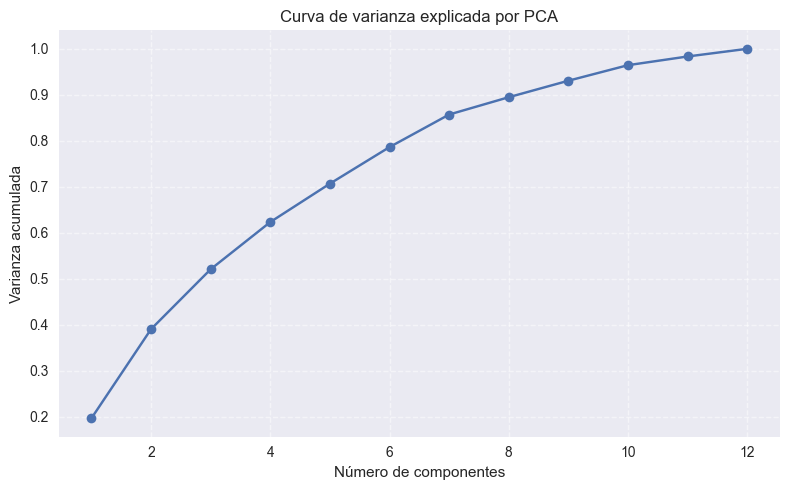

In [26]:
plt.plot(explained_variance['componente'], explained_variance['var_acumulada'], marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Curva de varianza explicada por PCA')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Interpretación:** Con ~6 componentes se retiene alrededor del 80% de la varianza numérica, útil si se necesita compactar el espacio antes de un modelo sensible a la dimensionalidad (p. ej. regresión lineal).


## 8. Próximos pasos sugeridos


- Entrenar un modelo base (p. ej. `RandomForestRegressor`, `GradientBoostingRegressor`) usando el pipeline de `preprocessor`.
- Validar con una métrica robusta (MAE) y comparar contra un baseline como la mediana.
- Explorar ingeniería específica del vecindario (densidad de listings, precio medio por zona) y disponibilidad.
- Evaluar estrategias de tuning (GridSearch/Optuna) y monitoreo de drift con `wandb`.
